## Imports and dataset

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [5]:
df = pd.read_csv("../data/screentime_dataset.csv")
df.columns = df.columns.str.strip().str.lower()

In [6]:
df.head()

,date,day_type,total_screen_time_min,pickups,most_used_category,social_min,productivity_finance_min,other_min,games_min,entertainment_min,utilities_min,information_reading_min,shopping_food_min,creativity_min,travel_min,health_fitness_min
0,2025-10-05,Weekend,260,76,Social,97,41,33,28,24,24,7,0,0,0,0
1,2025-10-06,Weekday,419,90,Social,276,27,43,42,14,11,0,7,0,0,0
2,2025-10-07,Weekday,342,90,Social,172,9,43,41,0,34,8,33,0,0,0
3,2025-10-08,Weekday,343,85,Social,156,0,80,80,0,12,6,36,11,0,0
4,2025-10-09,Weekday,350,105,Social,148,58,27,24,40,22,0,18,0,0,0


## Cleaning and Preprocessing

### Add ratios for better clusters

In [23]:
df["social_ratio"] = df["social_min"] / df["total_screen_time_min"]
df["productive_ratio"] = (df["productivity_finance_min"] + df["information_reading_min"] + df["health_fitness_min"]) / df["total_screen_time_min"]
df["entertainment_ratio"] = (df["games_min"] + df["entertainment_min"] + df["shopping_food_min"]) / df["total_screen_time_min"]

# Handle any NaN or inf values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(subset=["social_ratio", "productive_ratio", "entertainment_ratio"], inplace=True)

### Normalize values

In [24]:
X = df[["social_ratio", "productive_ratio", "entertainment_ratio"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Elbow method to see optimal number of clusters

c:\Users\Beast\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Beast\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Beast\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Beast\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

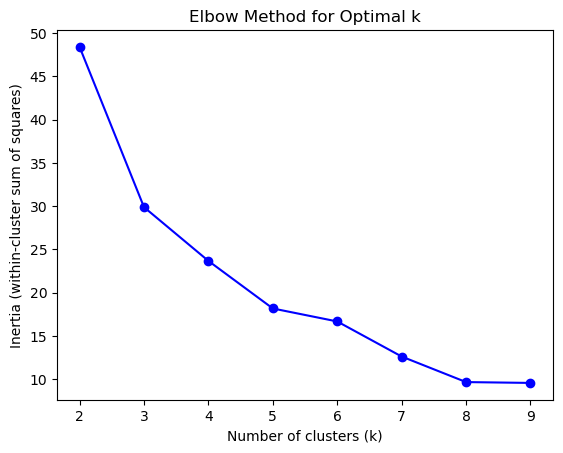

In [25]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, 'bo-')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (within-cluster sum of squares)")
plt.title("Elbow Method for Optimal k")
plt.show()


##### The elbow at k=5 shows diminishing returns beyond that in my opinion so 5 clusters were chosen

### Train on 5 clusters

In [26]:
kmeans = KMeans(n_clusters=5, random_state=42)
df["Cluster"] = kmeans.fit_predict(X_scaled)


c:\Users\Beast\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


### Set mappings for better interpretation

In [27]:
ratio_features = ["social_ratio", "productive_ratio", "entertainment_ratio"]

df.groupby("Cluster")[ratio_features + ["total_screen_time_min"]].mean().round(2)



,social_ratio,productive_ratio,entertainment_ratio,total_screen_time_min
Cluster,,,,
0,0.47,0.18,0.19,326.83
1,0.62,0.04,0.15,349.00
2,0.51,0.04,0.29,442.60
3,0.68,0.12,0.05,253.50
4,0.40,0.10,0.27,293.33


In [28]:
cluster_labels = {
    0: "Balanced Day",
    1: "Social-Heavy Day",
    2: "Entertainment-Heavy Day",
    3: "Short Social Day",
    4: "Moderate Mixed Day"
}

df["Cluster_Label"] = df["Cluster"].map(cluster_labels)

In [29]:
pd.crosstab(df["Cluster_Label"], df["day_type"], normalize="columns")


day_type,Weekday,Weekend
Cluster_Label,,
Balanced Day,0.25,0.125
Entertainment-Heavy Day,0.20,0.125
Moderate Mixed Day,0.15,0.375
Short Social Day,0.20,0.000
Social-Heavy Day,0.20,0.375


##### I see that my moderate mixed day has a significant jump on weekend from weekday which is probably from increased usage on all entertainment platforms but I believe mainly from the gaming side. I also see how on the weekend I have a ratio of 0 for short social day which tells me I do heavy socializing on a weekend and it is proved i the row below. I should work on reducing the social (tik tok especially) screen time especially on weekends. I do like how I am more balanced on a weekday but I can strive to be better by reducing all these numbers. p.s I do believe if I had more data I would have better representations and more accurate claims. Apple restricts screen time data through not allowing for a universal way to get access to the data and so had to resort to tedious scraping of this data using AI. 

## Plotting: Visualizing clusters and explainations

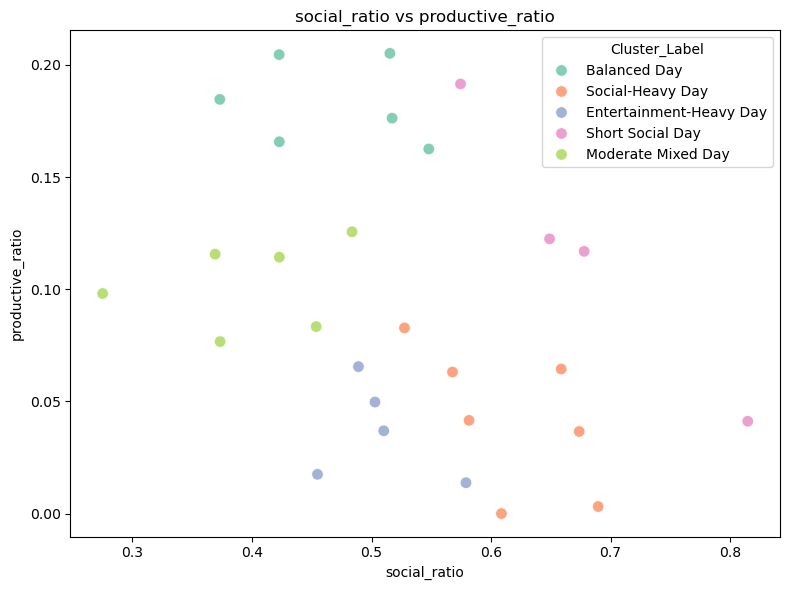

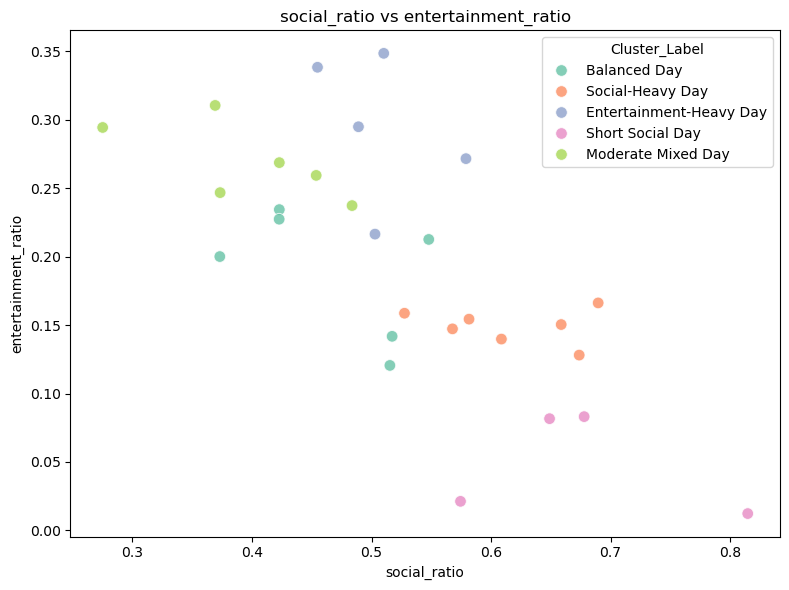

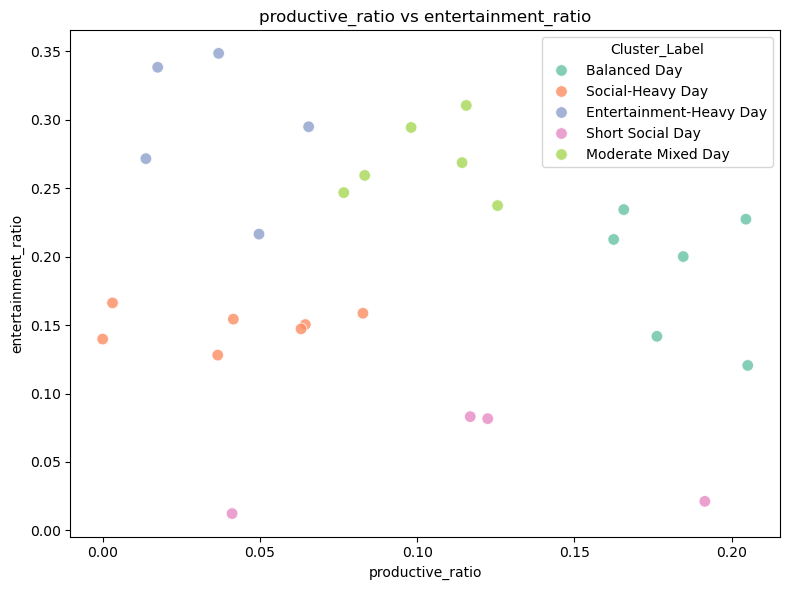

In [41]:
key_features = ["social_ratio", "productive_ratio", "entertainment_ratio"]

# Plot pairwise relationships between ratios
for i in range(len(key_features)):
    for j in range(i + 1, len(key_features)):
        x_label = key_features[i]
        y_label = key_features[j]

        plt.figure(figsize=(8, 6))
        sns.scatterplot(
            x=x_label,
            y=y_label,
            data=df,
            hue="Cluster_Label",
            palette="Set2",
            s=70,
            alpha=0.8
        )
        plt.title(f"{x_label} vs {y_label}")
        plt.tight_layout()
        plt.show()


### 1st plot (social ratio vs productive ratio) shows:
 - ##### Noticible clusters
 - ##### Some have high social but low productivity
 - ##### Others have moderate social with high productivity
##### This shows that when screen time is more "social" it seems to replace productive app usage
##### Implies a inverse relationship between focus and social activity


### 2nd plot (social ratio vs Entertainment ratio) shows:
 - ##### Noticible clusters but one discrepancy if anything
 - ##### Clusters 1 and 3 (orange and pink) show high social use and low entertainment
   - ##### Shows those days were dominated by social use rather than gaming or watch videos (good to know)
 - ##### Others show higher entertainment and still moderate entertainment usage


##### With this, the formation of a negative slop suggests that when socuial use is high, entertainment drops and vice versa


### 3rd plot (productive ratio vs entertainment ratio) shows:
 - ##### Noticible clusters: trade off between and productibity and entertainment
 - ##### Most clusters show when entertainment increases, productivity decreases.
   - ##### Shows days are **generally** focused with productivity or not with entertainment. Not both though
   - ##### For example the 2 cluster (blue) sits higher on entertainment but low on productivity


##### Confirms visually that time patterns have distinct focuses. I suppose I rarely spend equal time being productive and entertained on the same day. I guess I have change some things 

### Heatmap summary

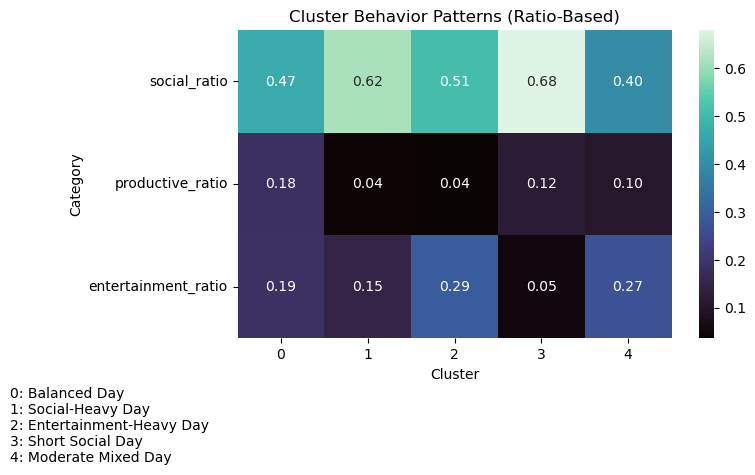

In [55]:
import seaborn as sns
df_grouped = df.groupby("Cluster")[["social_ratio", "productive_ratio", "entertainment_ratio"]].mean()


plt.figure(figsize=(7,4))
sns.heatmap(df_grouped.T, annot=True, cmap="mako", fmt=".2f")
plt.title("Cluster Behavior Patterns (Ratio-Based)")
plt.ylabel("Category")
plt.xlabel("Cluster")


# Add legend mapping as text
cluster_labels = {
    0: "Balanced Day",
    1: "Social-Heavy Day",
    2: "Entertainment-Heavy Day",
    3: "Short Social Day",
    4: "Moderate Mixed Day"
}

# Format legend text
legend_text = "\n".join([f"{k}: {v}" for k, v in cluster_labels.items()])
plt.figtext(-0.2, -0.2, legend_text, ha="left", fontsize=10)

plt.show()


#### Heatmap shows:
- ##### How each clusters differ in behavioral focus
- ##### Lighter cells show dominant activities in each group
  - ##### Social ratio has very light cells which correspond do social related clusters
  - ##### Entertainment ratio has light cells which correspond to entertainment and moderate mixed day
    - ##### Confirms my chosen mappings were accurate
##### This visualization also summarizes my screen time behaviour patterns and also confirms the k-means algorithm identified distinct daily habits rather than random variations 

## Important notes

### Data Wise:
- #### If I had more data I believe I could get better clusters without using ratios providing more meaningful conclusios
- #### This issue was caused mainly by apple not allowing for downloading of your own screen time so I had to work around this.

#### Work Around for Screen Time Data Collection:
- ##### Took screenshots for each days screen time (pdf included to see how)
- ##### Sent these pictures to ChatGPT in batches of 10 (max image per message)
  - ##### Asked ChatGPT to keep added this pictures to a CSV but that turnt out to be mistake prone
  - ##### Creative fix was to ask it for a python script where it extracts the screenshot data and adds it as an array in the python code until all screenshots were processed 
  - ##### All this can be found in the "script" folder

### Personal Wise

#### Trust me I am more productive, but since most of my work is done on my Windows PC and laptop which are not Apple devices, data could not transfer. Please hire me thanks